In [9]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [14]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [16]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [25]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
inspector.get_table_names()


['measurement', 'station']

In [27]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [32]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent)

('2017-08-23',)


Text(0, 0.5, 'Inches')

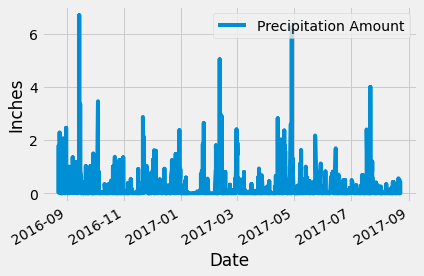

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = dt.datetime.strptime(recent[0],'%Y-%m-%d')

# Calculate the date one year from the last date in data set.
year_prior = dt.date(most_recent.year - 1, most_recent.month, most_recent.day)

# Perform a query to retrieve the data and precipitation scores
x = [Measurement.date, Measurement.prcp]
precip = session.query(*x).filter(Measurement.date >= year_prior).all()
#for row in precip:
    #print(row)
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns = ['Date','Precipitation Amount'])
precip_df['Date'] = pd.to_datetime(precip_df['Date'], format='%Y-%m-%d')
precip_df.set_index('Date',inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_index()
precip_df.dropna(inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot()
ax.set_ylabel('Inches')

In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation Amount
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [65]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [66]:
inspector = inspect(engine)
columns = inspector.get_columns('station')

In [67]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [74]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
stat_count = session.query(*sel).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
stat_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [71]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
t = Measurement.tobs
temps = [func.min(t), func.max(t), func.avg(t)]
temp_stats = session.query(*temps).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
temp_stats

(54.0, 85.0, 71.66378066378067)

Text(0.5, 0, 'Temperature')

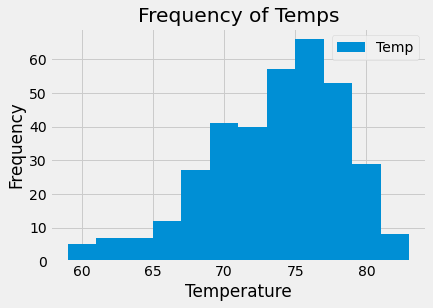

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
precips = session.query(Measurement.tobs).filter(Measurement.date >= year_prior).\
filter(Measurement.station == stat_count[0][0]).all()
df = pd.DataFrame(precips, columns = ['Temp'])
ax = df.plot.hist(bins=12)
ax.set_title('Frequency of Temps')
ax.set_xlabel('Temperature')

# Close session

In [90]:
# Close Session
session.close()